In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

In [2]:
import pycbc.waveform
import pycbc.filter
import pycbc.types

In [3]:
import scrinet.interfaces

In [4]:
import phenom

In [5]:
import lal

In [6]:
import scipy.signal

In [7]:
import scipy.optimize

In [8]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [9]:
def compute_freq_from_hp_hc(x, hp, hc):
    y = np.unwrap(np.angle(hp - 1.j * hc))
    return IUS(x, y).derivative()(x)/2/np.pi

In [10]:
def compute_freq_from_h(x, h):
    y = np.unwrap(np.angle(h))
    return IUS(x, y).derivative()(x)/2/np.pi

# gen waveforms

In [11]:
mtot = 60
q_arr = np.linspace(1, 10, 100)
m1_arr, m2_arr = phenom.m1_m2_M_q(mtot, q_arr)

f_lower = 10
delta_t = 1./4096.
distance_mpc = 1
distance_m = distance_mpc * 1e6 * lal.PC_SI

In [12]:
modelA = "IMRPhenomC"
modelB = "IMRPhenomD"

In [13]:
def get_t_at_flower(hp, hc, f_start, verbose=False):
    """
    inputs; hp, hc are pycbc.types.TimeSeries
    f_start: float value in Hz
    
    returns an estimate of the time at f_start
    
    """
    times = hp.sample_times.numpy().copy()
    
    freq = compute_freq_from_hp_hc(times, hp.numpy(), hc.numpy())
    
    # chop start and end
    # pc == post_chop
    pc_start_idx = int(len(freq) * 0.3)
    pc_end_idx = int(len(freq) * 0.92)
    
    if verbose:
        print(pc_start_idx, pc_end_idx)
    
    pc_start_time = times[pc_start_idx]
    pc_end_time = times[pc_end_idx]
    
    pc_start_freq = freq[pc_start_idx]
    pc_end_freq = freq[pc_end_idx]

    if verbose:
        print(f"pc start time: {pc_start_time}")
        print(f"pc start freq: {pc_start_freq}")
    
    mask1 = (times >= pc_start_time) & (times <= pc_end_time)
    m1_freq = freq[mask1]
    m1_time = hp.sample_times[mask1]
    
    # sg filter
    yhat = scipy.signal.savgol_filter(m1_freq, 101, 3)
    
    z = np.polyfit(m1_time, yhat, 6)
#     z = np.polyfit(yhat, m1_time, 6)
    p = np.poly1d(z)
    
    
    mask2 = p(m1_time) < -f_start
    
    t_at_f_lower = m1_time[mask2][0]
    if verbose:
        print(p(m1_time)[mask2][0])
        print(t_at_f_lower)
    
    
        plt.figure()
        plt.plot(m1_time, m1_freq)
        plt.plot(m1_time, yhat)
        plt.plot(m1_time, p(m1_time))
        plt.axvline(t_at_f_lower)
        plt.axhline(-f_lower)
        plt.show()

    return t_at_f_lower

In [14]:
def resample(x, y, newx):
    return IUS(x, y)(newx)

In [15]:
def truncate_to_common_times(model_dictlist, start_time=None, end_time=None, npts=5000):
    out_dict = []
    
    for i in range(len(model_dictlist)):
        times = model_dictlist[i]['times']
        amp = model_dictlist[i]['amp']
        phase = model_dictlist[i]['phase']
        freq = model_dictlist[i]['freq']
        
        if start_time is None:
            start_time = times[0]
        if end_time is None:
            end_time = times[-1]
        
        mask = (times >= start_time) * (times <= end_time)
        
        times = times[mask]
        
        newtimes = np.linspace(start_time, end_time, npts)
        
        out_dict.append({
            'times':newtimes,
            'amp':resample(times, amp[mask], newtimes),
            'phase':resample(times, phase[mask], newtimes),
            'freq':resample(times, freq[mask], newtimes)
        })
        
    return out_dict    

In [16]:
modelA_hp_wfs = []
modelA_hc_wfs = []
modelB_hp_wfs = []
modelB_hc_wfs = []

for i in range(q_arr.shape[0]):
    m1 = m1_arr[i]
    m2 = m2_arr[i]
    amp0 = scrinet.interfaces.lalutils.td_amp_scale(mtot, distance_m)
    
    hp_A, hc_A = pycbc.waveform.get_td_waveform(mass1=m1, mass2=m2, f_lower=f_lower, delta_t=delta_t, distance=distance_mpc, approximant="IMRPhenomC")
    hp_B, hc_B = pycbc.waveform.get_td_waveform(mass1=m1, mass2=m2, f_lower=f_lower, delta_t=delta_t, distance=distance_mpc, approximant="IMRPhenomD")
    
    start_time_A = get_t_at_flower(hp_A, hc_A, f_start=f_lower)
    start_time_B = get_t_at_flower(hp_B, hc_B, f_start=f_lower)

    mask_A = hp_A.sample_times > start_time_A
    mask_B = hp_B.sample_times > start_time_B
    
    hp_A = pycbc.types.TimeSeries(hp_A.numpy()[mask_A] / amp0, delta_t=hp_A.delta_t)
    hc_A = pycbc.types.TimeSeries(hc_A.numpy()[mask_A] / amp0, delta_t=hc_A.delta_t)
    hp_B = pycbc.types.TimeSeries(hp_B.numpy()[mask_B] / amp0, delta_t=hp_B.delta_t)
    hc_B = pycbc.types.TimeSeries(hc_B.numpy()[mask_B] / amp0, delta_t=hc_B.delta_t)
    
    h_complex_A = hp_A.numpy() - 1.j * hc_A.numpy()
    h_complex_B = hp_B.numpy() - 1.j * hc_B.numpy()
    
    amp_A = np.abs(h_complex_A)
    amp_B = np.abs(h_complex_B)
    
    tpeak_A = scrinet.interfaces.lalutils.peak_align_shift(hp_A.sample_times, amp_A, npts=1e6, dx_npts=10)
    tpeak_B = scrinet.interfaces.lalutils.peak_align_shift(hp_B.sample_times, amp_B, npts=1e6, dx_npts=10)
    
    hp_A = pycbc.types.TimeSeries(hp_A.numpy(), delta_t=hp_A.delta_t, epoch=-tpeak_A)
    hc_A = pycbc.types.TimeSeries(hc_A.numpy(), delta_t=hc_A.delta_t, epoch=-tpeak_A)
    hp_B = pycbc.types.TimeSeries(hp_B.numpy(), delta_t=hp_B.delta_t, epoch=-tpeak_B)
    hc_B = pycbc.types.TimeSeries(hc_B.numpy(), delta_t=hc_B.delta_t, epoch=-tpeak_B)
    
    modelA_hp_wfs.append(hp_A)
    modelA_hc_wfs.append(hc_A)
    
    modelB_hp_wfs.append(hp_B)
    modelB_hc_wfs.append(hc_B)
    
# do a post processing step where
# we resize all waveforms to be the same
# length, which is the length of the longest
# waveform.
lens_A = [len(a) for a in modelA_hp_wfs]
lens_B = [len(a) for a in modelB_hp_wfs]

maxA = max(lens_A)
maxB = max(lens_B)

maxmax = max([maxA, maxB])

for i in range(q_arr.shape[0]):
    modelA_hp_wfs[i].resize(maxmax)
    modelA_hc_wfs[i].resize(maxmax)
    modelB_hp_wfs[i].resize(maxmax)
    modelB_hc_wfs[i].resize(maxmax)

modelA_dictlist = []
modelB_dictlist = []

for i in range(q_arr.shape[0]):
    
    hp_A = modelA_hp_wfs[i]
    hc_A = modelA_hc_wfs[i]
    
    hp_B = modelB_hp_wfs[i]
    hc_B = modelB_hc_wfs[i]
    
    h_complex_A = hp_A.numpy() - 1.j * hc_A.numpy()
    h_complex_B = hp_B.numpy() - 1.j * hc_B.numpy()

    amp_A = np.abs(h_complex_A)
    amp_B = np.abs(h_complex_B)

    phase_A = np.unwrap(np.angle(h_complex_A))
    phase_B = np.unwrap(np.angle(h_complex_B))
    
    freq_A = compute_freq_from_h(hp_A.sample_times, h_complex_A)
    freq_B = compute_freq_from_h(hp_B.sample_times, h_complex_B)
    
    times_M_A = phenom.StoM(hp_A.sample_times, mtot)
    times_M_B = phenom.StoM(hp_B.sample_times, mtot)
#     times_A = hp_A.sample_times
#     times_B = hp_B.sample_times

    A_dict = {'times':times_M_A, 'amp':amp_A, 'phase':phase_A, 'freq':freq_A}
    B_dict = {'times':times_M_B, 'amp':amp_B, 'phase':phase_B, 'freq':freq_B}
    
    modelA_dictlist.append(A_dict)
    modelB_dictlist.append(B_dict)

In [17]:
modelA_dictlist = truncate_to_common_times(modelA_dictlist, start_time=-10000, end_time=100)
modelB_dictlist = truncate_to_common_times(modelB_dictlist, start_time=-10000, end_time=100)

# modelA_dictlist = truncate_to_common_times(modelA_dictlist)
# modelB_dictlist = truncate_to_common_times(modelB_dictlist)

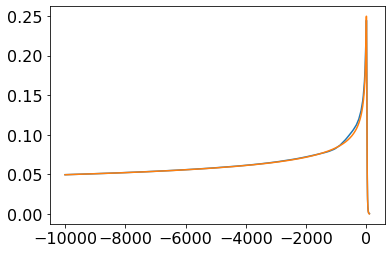

In [18]:
plt.figure()
plt.plot(modelA_dictlist[0]['times'], modelA_dictlist[0]['amp'])
plt.plot(modelB_dictlist[0]['times'], modelB_dictlist[0]['amp'])
# plt.xlim(-0.1,0.2)

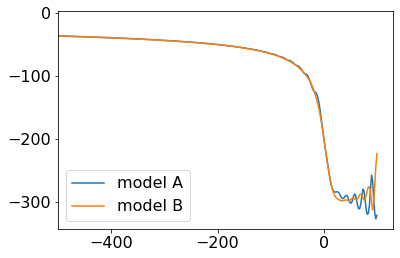

In [19]:
plt.figure()
plt.plot(modelA_dictlist[0]['times'], modelA_dictlist[0]['freq'], label='model A')
plt.plot(modelB_dictlist[0]['times'], modelB_dictlist[0]['freq'], label='model B')
plt.xlim(-500,130)
plt.legend()

In [20]:
list(range(0, 10, 2))

[0, 2, 4, 6, 8]

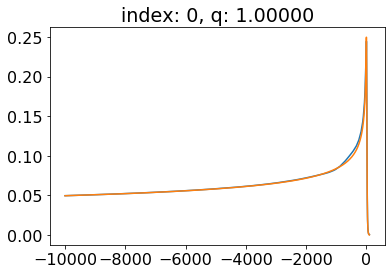

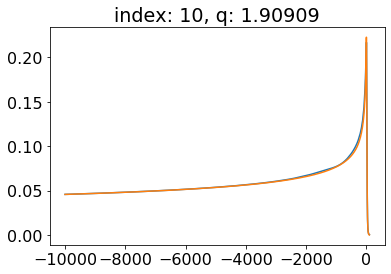

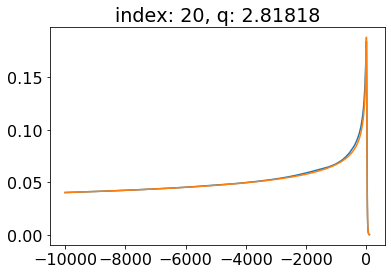

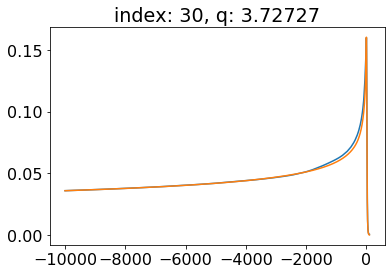

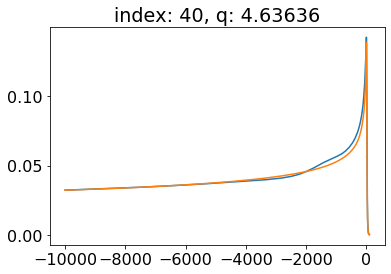

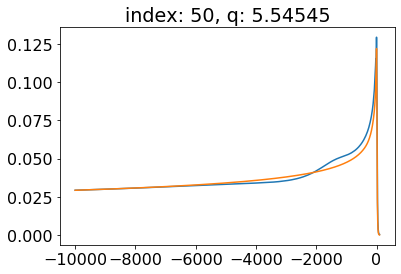

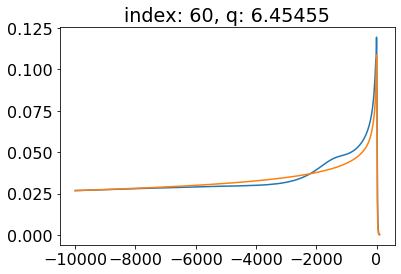

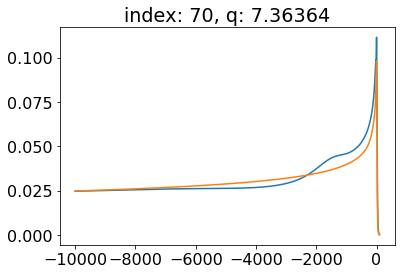

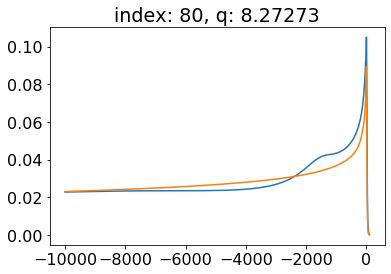

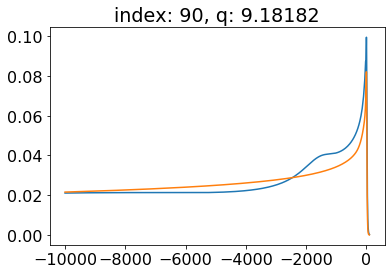

In [21]:
for i in range(0,len(modelA_dictlist),10):
    plt.figure()
    plt.plot(modelA_dictlist[i]['times'], modelA_dictlist[i]['amp'])
    plt.plot(modelB_dictlist[i]['times'], modelB_dictlist[i]['amp'])
    plt.title(f"index: {i}, q: {q_arr[i]:.5f}")
    plt.show()
    plt.close()

# start

In [22]:
np.testing.assert_array_almost_equal(modelA_dictlist[0]['times'], modelB_dictlist[1]['times'])

times = modelA_dictlist[0]['times']

modelA_amp = np.array([m['amp'] for m in modelA_dictlist])
modelA_phase = np.array([m['phase'] for m in modelA_dictlist])

modelB_amp = np.array([m['amp'] for m in modelB_dictlist])
modelB_phase = np.array([m['phase'] for m in modelB_dictlist])

In [23]:
modelA_amp.shape

(100, 5000)

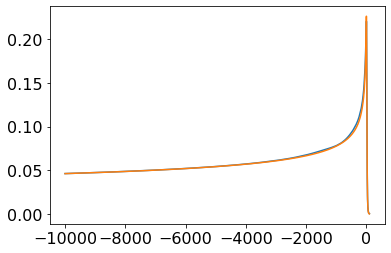

In [24]:
plt.figure()
plt.plot(times, modelA_amp[9])
plt.plot(times, modelB_amp[9])

## build rb

In [25]:
import rompy as rp

In [26]:
def build_basis(times, ts, greedy_tol, verbose=True, max_num_basis=None):
    
    if max_num_basis is None:
        max_num_basis = ts.shape[0]
    
    integration = rp.Integration(
        [times[0], times[-1]], len(times), rule="trapezoidal")
    x = integration.nodes
    rb = rp.ReducedBasis(integration)
    rb.make(ts, 0, greedy_tol, verbose=verbose, num=max_num_basis)
    
#     greedy_errors = rb.errors
#     nbasis = rb.size
#     greedy_points = ts_coords[rb.indices]
#     basis = rb.basis

    return rb

In [27]:
modelA_amp_rb = build_basis(times, modelA_amp, greedy_tol=1e-6)

('\nStep', '\t', 'Error')
(1, '\t', 46.726070538881046)
(2, '\t', 0.12286465779121691)
(3, '\t', 0.014499800784623318)
(4, '\t', 0.007782775631056893)
(5, '\t', 0.0008424006234761805)
(6, '\t', 0.0005427302654883448)
(7, '\t', 0.0003943109079571627)
(8, '\t', 1.859391226943785e-05)
(9, '\t', 5.4257319774819734e-06)
(10, '\t', 4.09809165802244e-06)
(11, '\t', 7.701178468266789e-07)


In [28]:
modelA_amp_greedy_points = q_arr[modelA_amp_rb.indices]

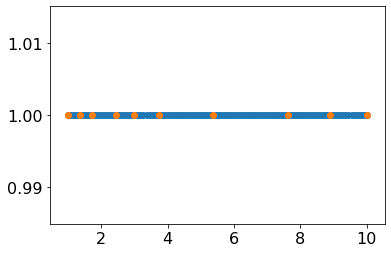

In [29]:
plt.figure()
plt.scatter(q_arr, np.ones_like(q_arr))
plt.scatter(modelA_amp_greedy_points, np.ones_like(modelA_amp_greedy_points))

In [30]:
modelA_amp_rb.basis.shape

(10, 5000)

In [31]:
modelA_amp_rb.alpha.shape

(10, 100)

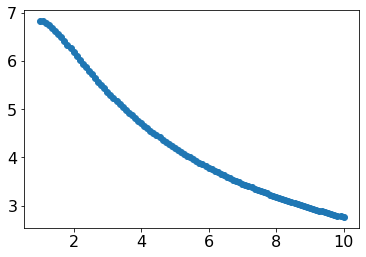

In [32]:
plt.figure()
plt.scatter(q_arr, modelA_amp_rb.alpha[0])

(10, 100)


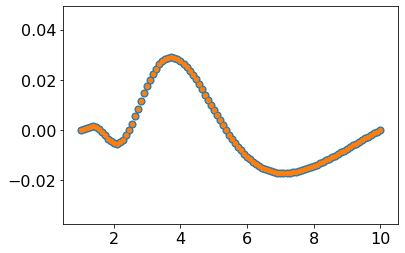

In [33]:
# check i can reproduce the alpha (projection coefficients)
# from modelA

# dot each basis onto the data to get coefficients

alpha = [modelA_amp_rb.alpha_arr(b, modelA_amp) for b in modelA_amp_rb.basis]
alpha = np.array(alpha)

print(alpha.shape)

plt.figure()
plt.scatter(q_arr, modelA_amp_rb.alpha[4], s=50)
plt.scatter(q_arr, alpha[4], s=20)

In [35]:
# project modelB_amp onto modelA_amp.basis
modelB_amp_onto_modelA = [modelA_amp_rb.alpha_arr(b, modelB_amp) for b in modelA_amp_rb.basis]
modelB_amp_onto_modelA = np.array(modelB_amp_onto_modelA)

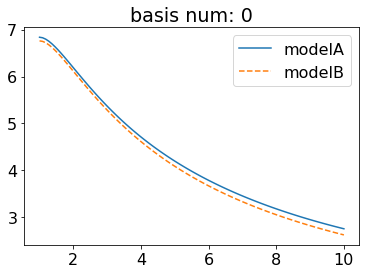

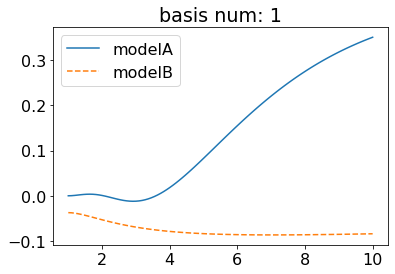

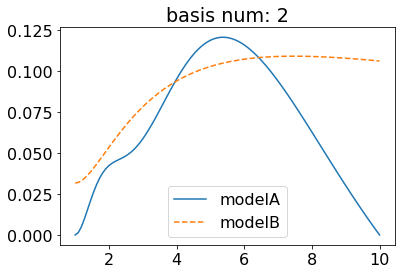

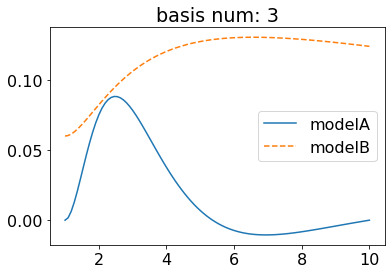

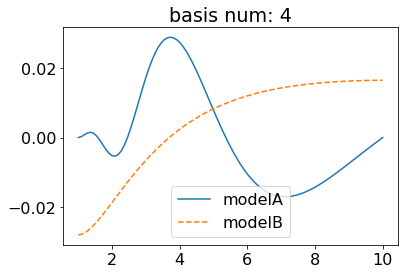

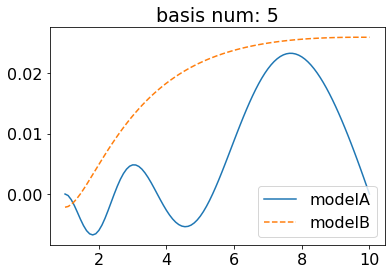

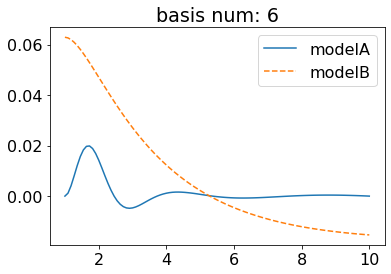

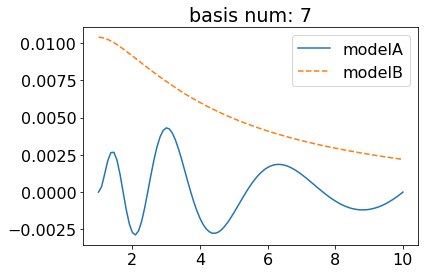

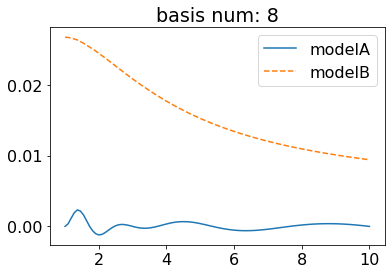

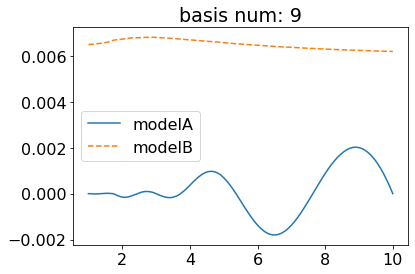

In [36]:
for i in range(modelA_amp_rb.size):
    plt.figure()
    plt.plot(q_arr, modelA_amp_rb.alpha[i], label='modelA')
    plt.plot(q_arr, modelB_amp_onto_modelA[i], label='modelB', ls='--')
    plt.title(f"basis num: {i}")
    plt.legend()
    plt.show()
    plt.close()

In [37]:
modelB_amp_prediction_from_modelA = np.dot(modelB_amp_onto_modelA[:,5], modelA_amp_rb.basis)

In [38]:
modelB_amp_prediction_from_modelA.shape

(5000,)

(-100, 100)

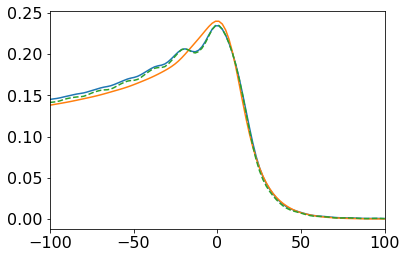

In [49]:
plt.figure()
plt.plot(times, modelA_amp[5])
plt.plot(times, modelB_amp[5])
plt.plot(times, modelB_amp_prediction_from_modelA, ls='--')
plt.xlim(-100, 100)
# plt.yscale('log')

# compute EIM and do the same

In [41]:
modelA_amp_eim = rp.EmpiricalInterpolant(modelA_amp_rb.basis, verbose=True)
# eim_basis = modelA_amp_eim.B
# eim_indices = modelA_amp_eim.indices


('\nStep', '\t', 'Nodes')
(1, '\t', 4950)
(2, '\t', 4961)
(3, '\t', 4918)
(4, '\t', 4032)
(5, '\t', 2027)
(6, '\t', 2752)
(7, '\t', 4391)
(8, '\t', 4223)
(9, '\t', 4528)
(10, '\t', 417)


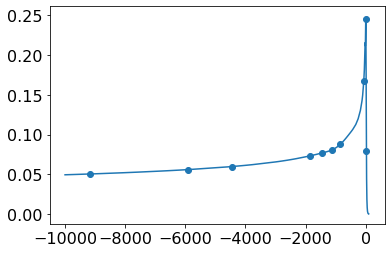

In [42]:
plt.figure()
plt.plot(times, modelA_amp[0])
plt.scatter(times[modelA_amp_eim.indices], modelA_amp[0][modelA_amp_eim.indices])

In [43]:
def make_data(ts, eim_indicies):
    return np.transpose(ts)[eim_indicies]

In [44]:
modelA_amp_eim_alpha = make_data(modelA_amp, modelA_amp_eim.indices)
modelB_amp_eim_alpha = make_data(modelB_amp, modelA_amp_eim.indices)

In [45]:
modelA_amp_eim_alpha.shape

(10, 100)

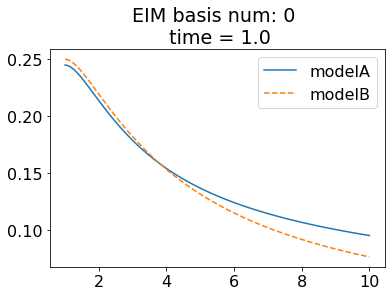

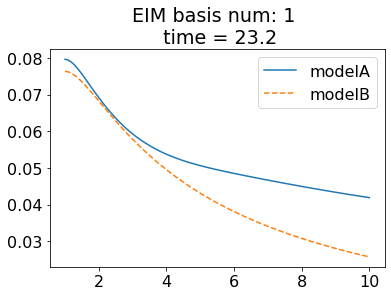

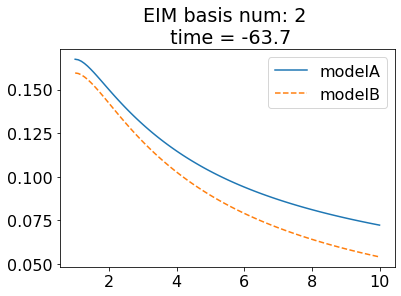

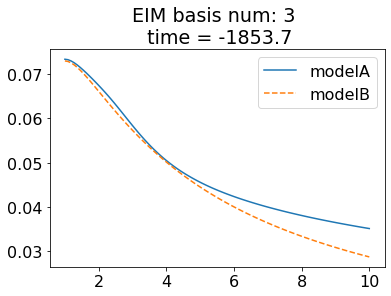

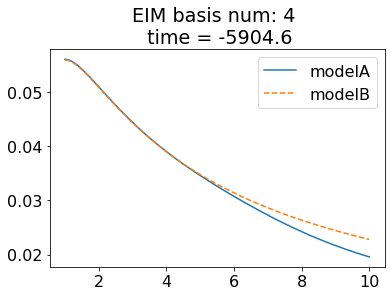

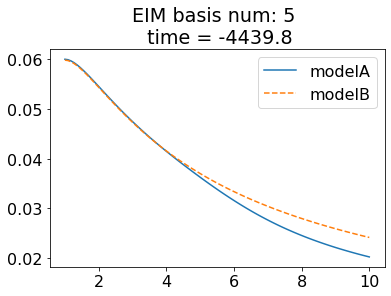

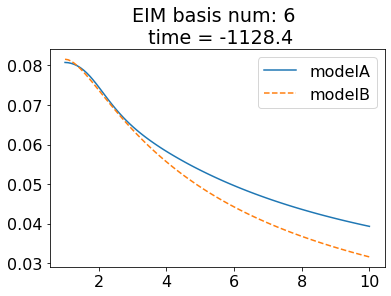

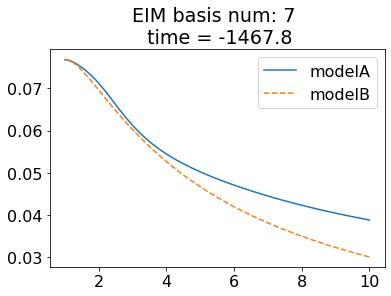

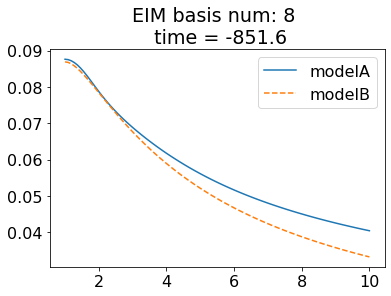

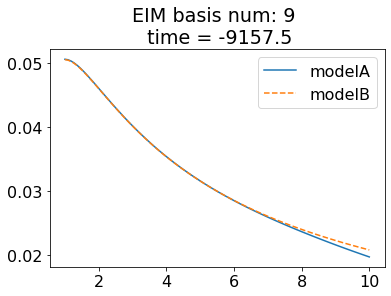

In [47]:
for i in range(modelA_amp_rb.size):
    plt.figure()
    plt.plot(q_arr, modelA_amp_eim_alpha[i], label='modelA')
    plt.plot(q_arr, modelB_amp_eim_alpha[i], label='modelB', ls='--')
    
    t_eim = times[modelA_amp_eim.indices[i]]
    plt.title(f"EIM basis num: {i} \n time = {t_eim:.1f}")
    plt.legend()
    plt.show()
    plt.close()

# try to add modelB waveforms to modelA basis

In [50]:
modelA_amp.shape

(100, 5000)

In [51]:
modelB_amp.shape

(100, 5000)

In [129]:
new_ts = np.row_stack((modelA_amp, modelB_amp[0], modelB_amp[-1]))

In [130]:
modelAB_amp_rb = build_basis(times, new_ts, greedy_tol=1e-6)

('\nStep', '\t', 'Error')
(1, '\t', 46.726070538881046)
(2, '\t', 0.12286465779121691)
(3, '\t', 0.03345915881612793)
(4, '\t', 0.012103810555657901)
(5, '\t', 0.009669453639595815)
(6, '\t', 0.0025304646676715947)
(7, '\t', 0.0009476654518465466)
(8, '\t', 0.0003002218023695491)
(9, '\t', 0.00010331101170990564)
(10, '\t', 7.446491250817644e-05)
(11, '\t', 4.3171616788129086e-06)
(12, '\t', 1.112134640379736e-06)
(13, '\t', 7.748263808338152e-07)


In [77]:
def predict(idx):
    # project modelB_amp onto modelA_amp.basis
    sec_modelB_amp_onto_modelA = [modelAB_amp_rb.alpha_arr(b, modelB_amp) for b in modelAB_amp_rb.basis]
    sec_modelB_amp_onto_modelA = np.array(sec_modelB_amp_onto_modelA)
    sec_modelB_amp_prediction_from_modelA = np.dot(sec_modelB_amp_onto_modelA[:,idx], modelAB_amp_rb.basis)
#     sec_modelB_amp_prediction_from_modelA.shape

    return sec_modelB_amp_prediction_from_modelA

In [78]:
prediction = predict(5)

(-100, 100)

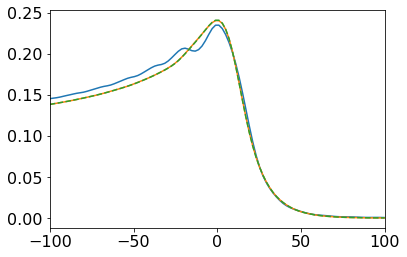

In [79]:
plt.figure()
plt.plot(times, modelA_amp[5])
plt.plot(times, modelB_amp[5])
plt.plot(times, prediction, ls='--')
plt.xlim(-100, 100)
# plt.yscale('log')

In [85]:
modelA_amp.shape

(100, 5000)

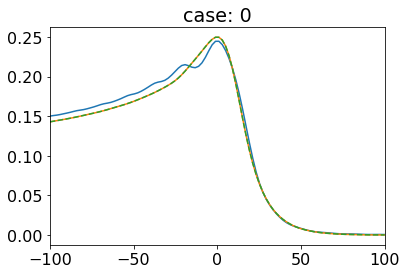

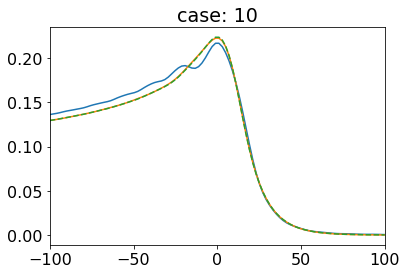

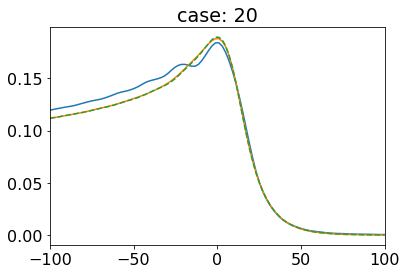

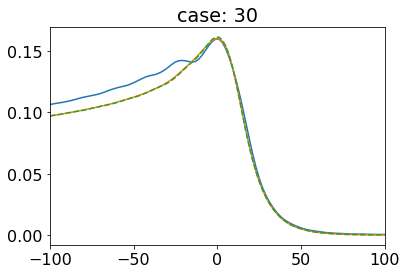

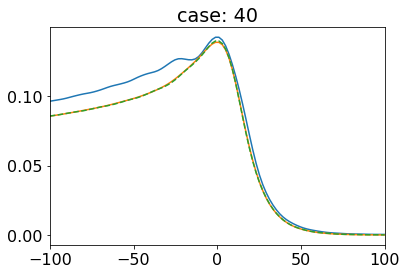

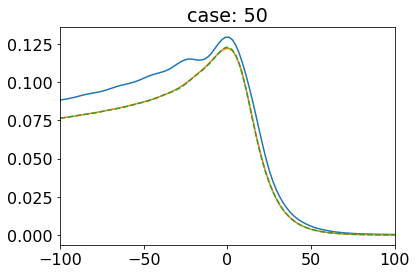

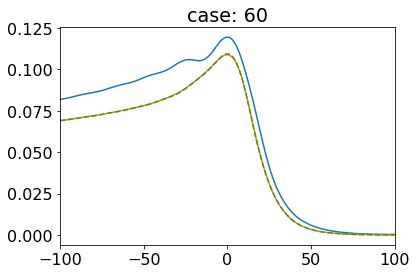

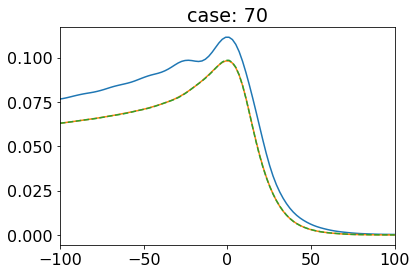

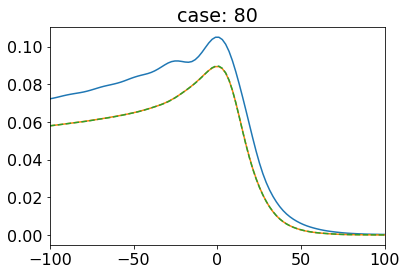

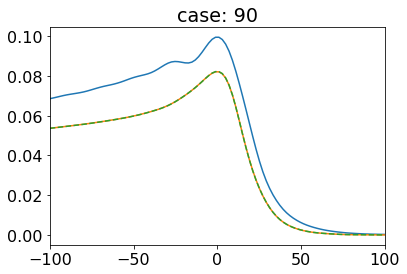

In [87]:
for i in range(0,modelA_amp.shape[0], 10):
    plt.figure()
    plt.plot(times, modelA_amp[i])
    plt.plot(times, modelB_amp[i])
    plt.plot(times, predict(i), ls='--')
    plt.xlim(-100, 100)
#     plt.xlim(-1000, 100)
#     plt.yscale('log')
    plt.title(f"case: {i}")
    plt.show()
    plt.close()

In [106]:
modelAB_amp_rb.basis.shape

(12, 5000)

In [107]:
modelAB_amp_rb.indices

array([  0,  99, 101, 100,  52,  13,  32,  76,  21,   6,  41,   9],
      dtype=int32)

In [112]:
np.concatenate((q_arr, [q_arr[0]], [q_arr[-1]]))[modelAB_amp_rb.indices]

array([ 1.        , 10.        , 10.        ,  1.        ,  5.72727273,
        2.18181818,  3.90909091,  7.90909091,  2.90909091,  1.54545455,
        4.72727273,  1.81818182])

In [88]:
# project modelB_amp onto modelA_amp.basis
sec_modelB_amp_onto_modelA = [modelAB_amp_rb.alpha_arr(b, modelB_amp) for b in modelAB_amp_rb.basis]
sec_modelB_amp_onto_modelA = np.array(sec_modelB_amp_onto_modelA)

In [90]:
modelAB_amp_rb.alpha.shape

(12, 102)

In [97]:
sec_modelB_amp_onto_modelA.shape

(12, 100)

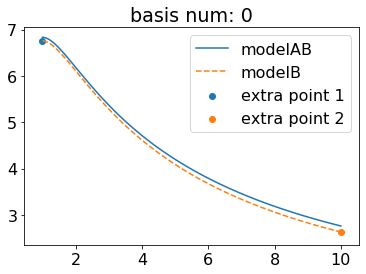

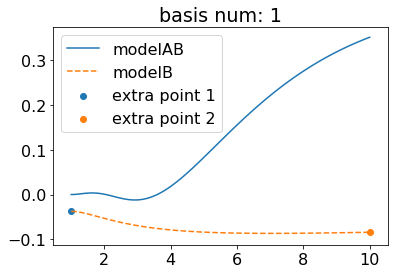

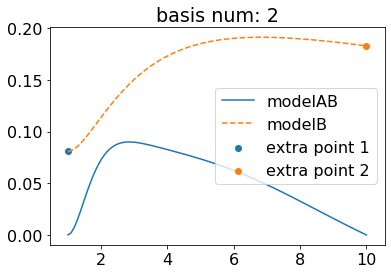

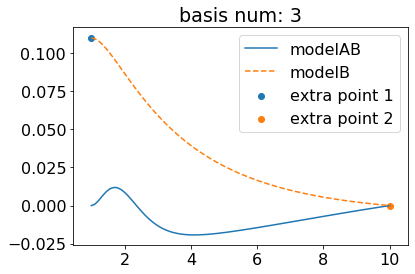

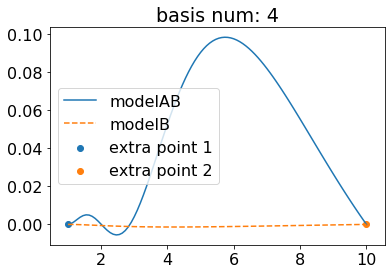

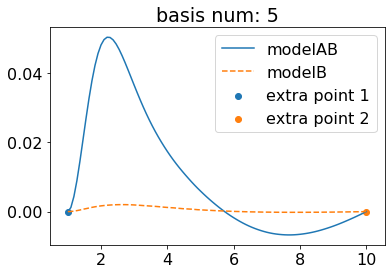

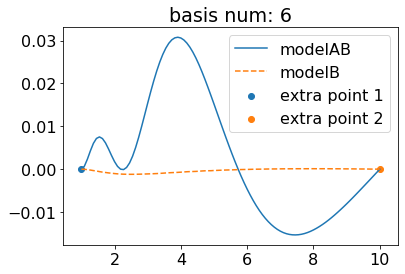

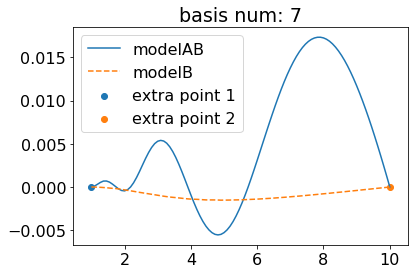

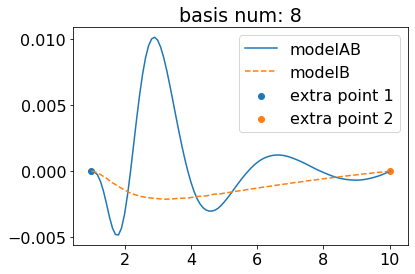

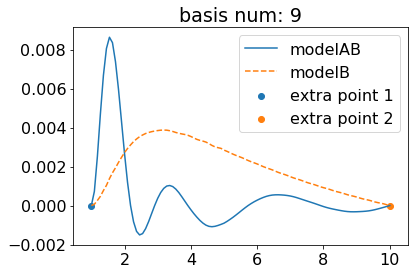

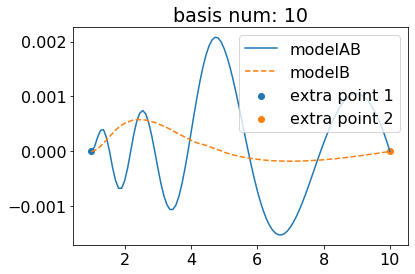

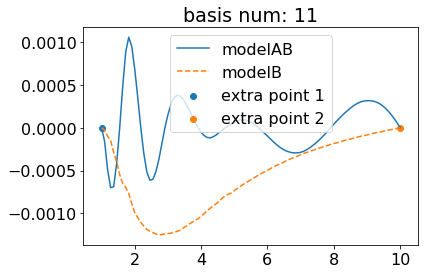

In [105]:
for i in range(modelAB_amp_rb.size):
    plt.figure()
    plt.plot(q_arr, modelAB_amp_rb.alpha[i][:-2], label='modelAB')
    plt.scatter(q_arr[0], modelAB_amp_rb.alpha[i][-2], label='extra point 1')
    plt.scatter(q_arr[-1], modelAB_amp_rb.alpha[i][-1], label='extra point 2')
    plt.plot(q_arr, sec_modelB_amp_onto_modelA[i], label='modelB', ls='--')
    plt.title(f"basis num: {i}")
    plt.legend()
    plt.show()
    plt.close()

# compute EIM and do the same

In [113]:
modelAB_amp_eim = rp.EmpiricalInterpolant(modelAB_amp_rb.basis, verbose=True)
# eim_basis = modelAB_amp_eim.B
# eim_indices = modelAB_amp_eim.indices


('\nStep', '\t', 'Nodes')
(1, '\t', 4950)
(2, '\t', 4961)
(3, '\t', 4411)
(4, '\t', 4939)
(5, '\t', 3834)
(6, '\t', 2348)
(7, '\t', 4178)
(8, '\t', 1079)
(9, '\t', 4927)
(10, '\t', 3322)
(11, '\t', 3003)
(12, '\t', 4518)


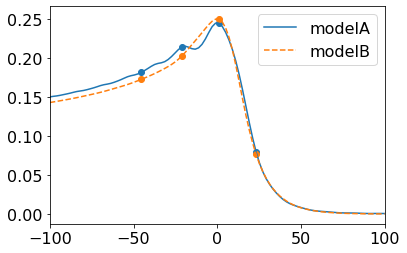

In [146]:
plt.figure()
plt.plot(times, modelA_amp[0], label='modelA')
plt.scatter(times[modelAB_amp_eim.indices], modelA_amp[0][modelAB_amp_eim.indices])


plt.plot(times, modelB_amp[0], ls='--', label='modelB')
plt.scatter(times[modelAB_amp_eim.indices], modelB_amp[0][modelAB_amp_eim.indices])

plt.xlim(-100,100)
plt.legend()

In [162]:
# sec_q_arr = np.concatenate((q_arr, [q_arr[0]], [q_arr[-1]]))

In [163]:
# sec_q_arr.shape

In [164]:
q_arr.shape

(100,)

(12, 100)
(12, 100)
SCALE_BY_ETA = False


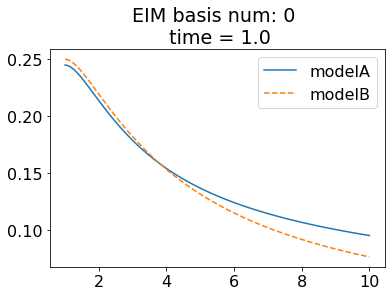

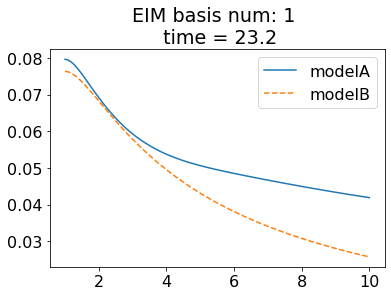

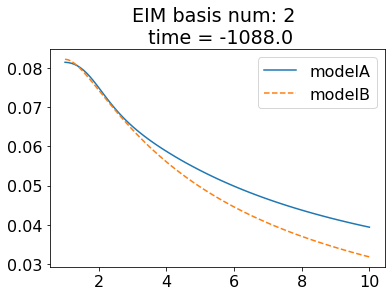

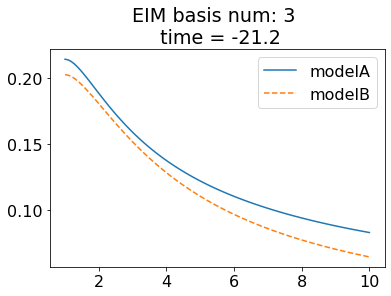

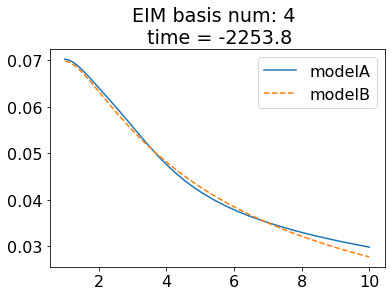

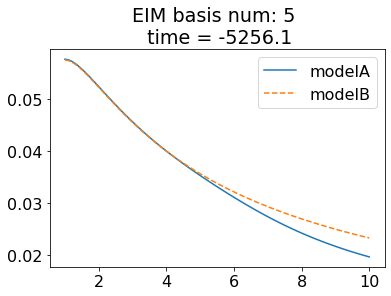

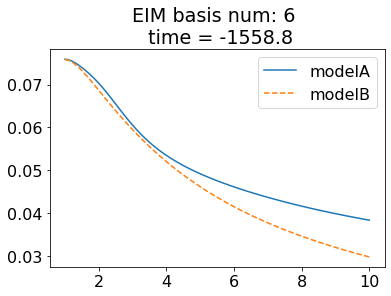

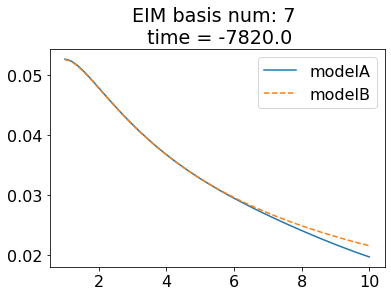

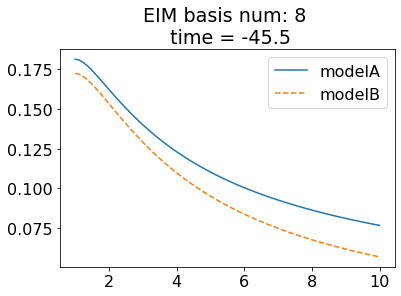

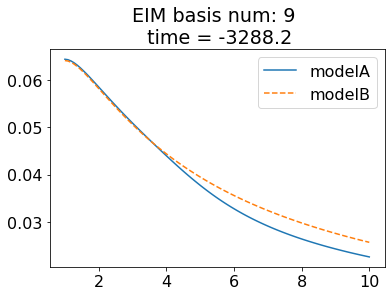

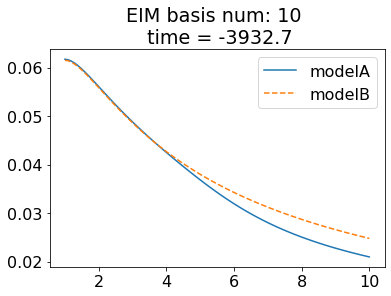

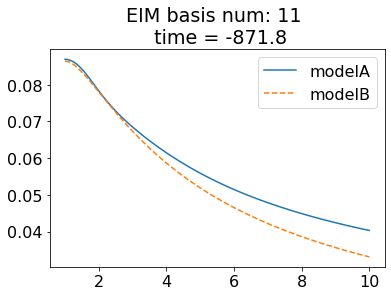

In [169]:
# new_ts
sec_modelA_amp_eim_alpha = make_data(modelA_amp, modelAB_amp_eim.indices)
sec_modelB_amp_eim_alpha = make_data(modelB_amp, modelAB_amp_eim.indices)

print(sec_modelA_amp_eim_alpha.shape)
print(sec_modelB_amp_eim_alpha.shape)

SCALE_BY_ETA=False
eta_scale = phenom.eta_from_q(q_arr)

print(f"SCALE_BY_ETA = {SCALE_BY_ETA}")

for i in range(modelAB_amp_rb.size):
    plt.figure()
    
    y1 = sec_modelA_amp_eim_alpha[i]
    y2 = sec_modelB_amp_eim_alpha[i]
    
    if SCALE_BY_ETA:
        y1 /= eta_scale
        y2 /= eta_scale
    
    plt.plot(q_arr, y1, label='modelA')
    plt.plot(q_arr, y2, label='modelB', ls='--')

#     plt.plot(sec_q_arr, sec_modelA_amp_eim_alpha[i], label='modelA')
#     plt.plot(sec_q_arr, sec_modelB_amp_eim_alpha[i], label='modelB', ls='--')
    
    t_eim = times[modelAB_amp_eim.indices[i]]
    plt.title(f"EIM basis num: {i} \n time = {t_eim:.1f}")
    plt.legend()
    plt.show()
    plt.close()